In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint


2025-01-05 23:48:04.418082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 23:48:04.430510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736117284.489626 1606554 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736117284.501402 1606554 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 23:48:04.528796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Define the file paths
subdirectory = "pickle_data_Brot"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (1819, 30)
Loaded Validation features dimensions: (0, 30)
Loaded Test features dimensions: (355, 30)

Loaded Training labels dimensions: (1819, 1)
Loaded Validation labels dimensions: (0, 1)

First few rows of loaded training features:
   Temp_Very_Cold_current  Temp_Cold_current  Temp_Mild_current  \
0                       0                  0                  1   
1                       0                  0                  1   
2                       0                  0                  0   
3                       0                  0                  1   
4                       0                  0                  1   

   Temp_Warm_current  Temp_Hot_current  Cloud_ok_current  \
0                  0                 0                 0   
1                  0                 0                 1   
2                  1                 0                 0   
3                  0                 0                 0   
4                  0    

In [3]:
#Defining the Neural Network
#Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.

model = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    Dropout(0.1),
    Dense(50, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),
    Dropout(0.15),
    Dense(25, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.01)),

    Dense(1)
])

model.summary()

I0000 00:00:1736117286.929511 1606554 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# SGD with optimized parameters
optimizer = SGD(
    #learning_rate=0.003, durch den lr_scheduler geregelt
    momentum=0.9,    # Add momentum to help escape local minima
    nesterov=True,   # Use Nesterov momentum for better convergence
)

model.compile(
    loss="huber",    # More robust to outliers
    optimizer=optimizer,
    metrics=['mape']
)

# Custom learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 50.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return max(lr, 1e-5)  # Don't let LR get too small

history = model.fit(
    training_features, 
    training_labels, 
    epochs=500,
    batch_size=8,   # Smaller batch size works better with SGD
    verbose=1,
    validation_data=(validation_features, validation_labels),
    callbacks=[
        EarlyStopping(
            monitor='mape',
            patience=20,
            restore_best_weights=True,
            mode='min'
        ),
        LearningRateScheduler(lr_schedule),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

Epoch 1/500


I0000 00:00:1736117292.606042 1606640 service.cc:148] XLA service 0x7fb0200050b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736117292.606111 1606640 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-05 23:48:12.622949: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736117292.681108 1606640 cuda_dnn.cc:529] Loaded cuDNN version 90300


 51/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118.0035 - mape: 98.3493

I0000 00:00:1736117293.862602 1606640 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 87.5187 - mape: 71.5815 - learning_rate: 0.0010
Epoch 2/500
 17/228 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 27.3332 - mape: 21.5812

2025-01-05 23:48:16.125834: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-05 23:48:16.125892: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:48:16.125902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:16.125920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832
/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batche

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 27.7603 - mape: 22.4943 - learning_rate: 0.0010
Epoch 3/500
 64/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.5728 - mape: 23.1515

2025-01-05 23:48:17.104687: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:48:17.104726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:17.104745: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.6087 - mape: 22.4924 - learning_rate: 0.0010
Epoch 4/500
 11/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 25.9902 - mape: 20.6430   

2025-01-05 23:48:17.641025: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:17.641067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25.7606 - mape: 21.3676 - learning_rate: 0.0010
Epoch 5/500
 59/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.6270 - mape: 23.9099

2025-01-05 23:48:18.314474: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:48:18.314509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:18.314527: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.2215 - mape: 22.5611 - learning_rate: 0.0010
Epoch 6/500
 48/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.3905 - mape: 22.7907

2025-01-05 23:48:18.866675: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:18.866718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.8576 - mape: 21.5238 - learning_rate: 0.0010
Epoch 7/500
 80/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.9878 - mape: 22.4712

2025-01-05 23:48:19.504974: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:19.505019: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.8293 - mape: 21.7041 - learning_rate: 0.0010
Epoch 8/500
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.9550 - mape: 20.0985

2025-01-05 23:48:19.989178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:19.989250: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.4888 - mape: 20.6109 - learning_rate: 0.0010
Epoch 9/500
 51/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.0380 - mape: 22.2276

2025-01-05 23:48:20.518001: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:48:20.518042: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:20.518062: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.4250 - mape: 21.0941 - learning_rate: 0.0010
Epoch 10/500
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.0534 - mape: 21.8219

2025-01-05 23:48:21.198875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:21.198918: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 24.6211 - mape: 21.1588 - learning_rate: 0.0010
Epoch 11/500
 12/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 23.0735 - mape: 19.8709   

2025-01-05 23:48:21.730843: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:21.730896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.7773 - mape: 20.8012 - learning_rate: 0.0010
Epoch 12/500
 61/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.3367 - mape: 20.5458

2025-01-05 23:48:22.409471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:22.409516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.3824 - mape: 20.2055 - learning_rate: 0.0010
Epoch 13/500
 56/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.0778 - mape: 20.7996

2025-01-05 23:48:22.994793: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:22.994838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ -1s -6207us/step - loss: 23.7350 - mape: 20.6154 - learning_rate: 0.0010
Epoch 14/500
 59/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.8350 - mape: 19.0901

2025-01-05 23:48:23.564489: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:23.564533: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.7679 - mape: 19.7175 - learning_rate: 0.0010
Epoch 15/500
 45/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.5218 - mape: 21.2890

2025-01-05 23:48:22.238229: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:22.238275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.6805 - mape: 20.7905 - learning_rate: 0.0010
Epoch 16/500
 52/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2287 - mape: 18.3724

2025-01-05 23:48:22.853443: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:22.853505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.8190 - mape: 19.3347 - learning_rate: 0.0010
Epoch 17/500
 54/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.6858 - mape: 22.0730

2025-01-05 23:48:23.592373: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:48:23.592423: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:23.592476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.1428 - mape: 20.8803 - learning_rate: 0.0010
Epoch 18/500
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.7802 - mape: 19.8764

2025-01-05 23:48:24.234655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:24.234750: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.8796 - mape: 19.8677 - learning_rate: 0.0010
Epoch 19/500
 41/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.2776 - mape: 19.9507

2025-01-05 23:48:24.830024: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:24.830067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.8634 - mape: 20.4081 - learning_rate: 0.0010
Epoch 20/500
 41/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.4673 - mape: 17.8196

2025-01-05 23:48:25.534806: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:25.534850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.7479 - mape: 19.4110 - learning_rate: 0.0010
Epoch 21/500
 65/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.4370 - mape: 18.1772

2025-01-05 23:48:26.368657: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:26.368706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.0279 - mape: 19.5460 - learning_rate: 0.0010
Epoch 22/500
 43/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.7397 - mape: 18.4808

2025-01-05 23:48:26.912620: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:26.912664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.5122 - mape: 19.5859 - learning_rate: 0.0010
Epoch 23/500
 50/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.3326 - mape: 20.2446

2025-01-05 23:48:27.615145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:27.615195: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.4615 - mape: 19.7019 - learning_rate: 0.0010
Epoch 24/500
 42/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.3693 - mape: 19.7053

2025-01-05 23:48:28.426804: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:28.426886: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.1480 - mape: 20.1450 - learning_rate: 0.0010
Epoch 25/500
 56/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.0272 - mape: 19.1599

2025-01-05 23:48:29.085100: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:29.085147: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.7187 - mape: 19.9641 - learning_rate: 0.0010
Epoch 26/500
 53/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.4212 - mape: 18.3035

2025-01-05 23:48:29.776646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:29.776692: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.1144 - mape: 19.6888 - learning_rate: 0.0010
Epoch 27/500
 61/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.7358 - mape: 19.5963

2025-01-05 23:48:30.355999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:30.356081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.9646 - mape: 19.4358 - learning_rate: 0.0010
Epoch 28/500
 54/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6248 - mape: 19.6246

2025-01-05 23:48:30.938013: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:30.938065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.4101 - mape: 19.8320 - learning_rate: 0.0010
Epoch 29/500
 58/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.1616 - mape: 22.0353

2025-01-05 23:48:31.583931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:31.583977: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.3999 - mape: 20.1046 - learning_rate: 0.0010
Epoch 30/500
 78/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.7804 - mape: 19.8869

2025-01-05 23:48:32.161083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:32.161160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.1984 - mape: 20.1225 - learning_rate: 0.0010
Epoch 31/500
 55/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6787 - mape: 18.9114

2025-01-05 23:48:32.763747: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:32.763805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.4139 - mape: 19.5895 - learning_rate: 0.0010
Epoch 32/500
 76/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.5357 - mape: 19.4493

2025-01-05 23:48:33.385175: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:33.385219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.0188 - mape: 19.6205 - learning_rate: 0.0010
Epoch 33/500
 52/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.3026 - mape: 21.9416

2025-01-05 23:48:33.924778: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:48:33.924819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:33.924838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.8862 - mape: 20.2902 - learning_rate: 0.0010
Epoch 34/500
 74/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.9695 - mape: 19.8263

2025-01-05 23:48:34.701254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:34.701334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.6320 - mape: 19.6853 - learning_rate: 0.0010
Epoch 35/500
 47/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.5883 - mape: 18.1602

2025-01-05 23:48:35.235853: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:35.235914: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.5285 - mape: 19.2169 - learning_rate: 0.0010
Epoch 36/500
 62/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.4274 - mape: 19.0242

2025-01-05 23:48:36.023083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:36.023131: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.4041 - mape: 19.4499 - learning_rate: 0.0010
Epoch 37/500
 53/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.5134 - mape: 19.7323

2025-01-05 23:48:36.636668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:36.636712: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.7935 - mape: 19.3504 - learning_rate: 0.0010
Epoch 38/500
 76/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5991 - mape: 18.9971

2025-01-05 23:48:37.228011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:37.228067: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.5847 - mape: 19.4670 - learning_rate: 0.0010
Epoch 39/500
 46/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.8328 - mape: 20.4071

2025-01-05 23:48:37.855960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:37.855999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.7693 - mape: 19.9285 - learning_rate: 0.0010
Epoch 40/500
 44/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.5882 - mape: 19.3089

2025-01-05 23:48:38.558445: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:38.558516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.8743 - mape: 19.0882 - learning_rate: 0.0010
Epoch 41/500
 36/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.2893 - mape: 21.7338

2025-01-05 23:48:39.371316: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:39.371364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.5742 - mape: 19.9957 - learning_rate: 0.0010
Epoch 42/500
 44/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.2772 - mape: 19.1867

2025-01-05 23:48:40.065596: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:40.065673: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.0813 - mape: 19.4337 - learning_rate: 0.0010
Epoch 43/500
 67/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8491 - mape: 18.6563

2025-01-05 23:48:40.785769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:40.785820: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.6115 - mape: 19.2366 - learning_rate: 0.0010
Epoch 44/500
 66/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8108 - mape: 18.7550

2025-01-05 23:48:41.540754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:41.540809: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.8501 - mape: 19.6458 - learning_rate: 0.0010
Epoch 45/500
 66/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.2384 - mape: 19.9383

2025-01-05 23:48:42.330830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:42.330892: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.7076 - mape: 19.4754 - learning_rate: 0.0010
Epoch 46/500
 53/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.9016 - mape: 18.2398

2025-01-05 23:48:42.994108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:42.994184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.8752 - mape: 19.1943 - learning_rate: 0.0010
Epoch 47/500
 32/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.8253 - mape: 22.5013

2025-01-05 23:48:43.711455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:43.711506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.0594 - mape: 20.2000 - learning_rate: 0.0010
Epoch 48/500
 40/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.1715 - mape: 20.0254

2025-01-05 23:48:44.507864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:44.507946: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.3984 - mape: 19.7819 - learning_rate: 0.0010
Epoch 49/500
 47/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.1174 - mape: 17.9689

2025-01-05 23:48:45.297151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:45.297244: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.5590 - mape: 19.6732 - learning_rate: 0.0010
Epoch 50/500
 51/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.8490 - mape: 22.4769

2025-01-05 23:48:45.964251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:45.964333: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.2256 - mape: 19.9744 - learning_rate: 5.0000e-04
Epoch 51/500
 54/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.0290 - mape: 19.6090

2025-01-05 23:48:46.592815: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:46.592862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.2836 - mape: 19.5353 - learning_rate: 5.0000e-04
Epoch 52/500
 70/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3997 - mape: 18.9499

2025-01-05 23:48:47.215710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:47.215769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.6191 - mape: 19.2507 - learning_rate: 5.0000e-04
Epoch 53/500
 72/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.5206 - mape: 20.9458

2025-01-05 23:48:47.741193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:47.741242: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.5097 - mape: 20.1605 - learning_rate: 5.0000e-04
Epoch 54/500
 70/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.5496 - mape: 18.6169

2025-01-05 23:48:48.326111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:48.326158: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.5590 - mape: 19.0221 - learning_rate: 5.0000e-04
Epoch 55/500
 66/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.4848 - mape: 19.5346

2025-01-05 23:48:48.836954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:48.836999: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.9417 - mape: 19.4821 - learning_rate: 5.0000e-04
Epoch 56/500
 58/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.9428 - mape: 18.2195

2025-01-05 23:48:49.525904: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:49.525960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.5142 - mape: 19.5907 - learning_rate: 5.0000e-04
Epoch 57/500
 79/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.0953 - mape: 19.8977

2025-01-05 23:48:50.141745: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:50.141796: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.0438 - mape: 19.7149 - learning_rate: 5.0000e-04
Epoch 58/500
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.1336 - mape: 20.3160

2025-01-05 23:48:50.717734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:50.717813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.8313 - mape: 19.9316 - learning_rate: 5.0000e-04
Epoch 59/500
 37/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.6391 - mape: 18.4343

2025-01-05 23:48:51.346398: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:51.346442: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.0351 - mape: 19.1261 - learning_rate: 5.0000e-04
Epoch 60/500
 75/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1902 - mape: 20.1269

2025-01-05 23:48:52.220557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:52.220618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.9645 - mape: 19.5511 - learning_rate: 5.0000e-04
Epoch 61/500
 46/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.3431 - mape: 18.7677

2025-01-05 23:48:52.911235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:52.911322: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.7306 - mape: 19.3015 - learning_rate: 5.0000e-04
Epoch 62/500
 40/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.1120 - mape: 17.8906

2025-01-05 23:48:53.690299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:53.690361: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ -1s -5606us/step - loss: 21.7501 - mape: 18.9297 - learning_rate: 5.0000e-04
Epoch 63/500
 58/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.0850 - mape: 20.3588

2025-01-05 23:48:52.467210: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:52.467262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.8961 - mape: 19.8125 - learning_rate: 5.0000e-04
Epoch 64/500
 43/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.4125 - mape: 22.0611

2025-01-05 23:48:53.114154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:53.114202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.0914 - mape: 19.6959 - learning_rate: 5.0000e-04
Epoch 65/500


2025-01-05 23:48:53.830824: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-01-05 23:48:53.830861: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:53.830882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 21.7853 - mape: 19.0855 - learning_rate: 5.0000e-04
Epoch 66/500
 44/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.4486 - mape: 18.4773

2025-01-05 23:48:55.299134: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:55.299183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.2035 - mape: 18.9561 - learning_rate: 5.0000e-04
Epoch 67/500
 58/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.0481 - mape: 18.9159

2025-01-05 23:48:56.061769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:56.061817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.9035 - mape: 18.6233 - learning_rate: 5.0000e-04
Epoch 68/500
 52/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.2959 - mape: 20.1625

2025-01-05 23:48:56.703979: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:56.704047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.7748 - mape: 19.4930 - learning_rate: 5.0000e-04
Epoch 69/500
 44/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.9973 - mape: 19.9443

2025-01-05 23:48:57.384478: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:57.384598: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.5283 - mape: 19.1804 - learning_rate: 5.0000e-04
Epoch 70/500
 44/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.7576 - mape: 19.7432

2025-01-05 23:48:58.063270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:58.063319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.2911 - mape: 19.0815 - learning_rate: 5.0000e-04
Epoch 71/500
 82/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2534 - mape: 17.6887

2025-01-05 23:48:58.863449: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:58.863522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.9055 - mape: 18.4991 - learning_rate: 5.0000e-04
Epoch 72/500
 40/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.3664 - mape: 18.0620

2025-01-05 23:48:59.527177: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:48:59.527226: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.6198 - mape: 18.2888 - learning_rate: 5.0000e-04
Epoch 73/500
 56/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.3560 - mape: 19.4865

2025-01-05 23:49:00.267178: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:00.267234: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.7004 - mape: 19.0900 - learning_rate: 5.0000e-04
Epoch 74/500
 62/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.8835 - mape: 19.9930

2025-01-05 23:49:00.842694: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:00.842766: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.4052 - mape: 20.0395 - learning_rate: 5.0000e-04
Epoch 75/500
 50/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.1868 - mape: 21.4981

2025-01-05 23:49:01.413770: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:01.413819: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.4213 - mape: 20.2091 - learning_rate: 5.0000e-04
Epoch 76/500
 73/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9353 - mape: 20.8199

2025-01-05 23:49:02.035701: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:02.035749: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.7885 - mape: 19.8113 - learning_rate: 5.0000e-04
Epoch 77/500
 49/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.5261 - mape: 16.5430

2025-01-05 23:49:02.586289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:02.586338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.9640 - mape: 18.0807 - learning_rate: 5.0000e-04
Epoch 78/500
 60/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.2664 - mape: 19.3456

2025-01-05 23:49:03.266968: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:03.267018: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.6434 - mape: 19.2093 - learning_rate: 5.0000e-04
Epoch 79/500
 52/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.7764 - mape: 18.4957

2025-01-05 23:49:04.042082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:04.042161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.7668 - mape: 18.4780 - learning_rate: 5.0000e-04
Epoch 80/500
 72/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7251 - mape: 16.3116

2025-01-05 23:49:04.748230: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:04.748306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.4574 - mape: 18.0611 - learning_rate: 5.0000e-04
Epoch 81/500
 63/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9821 - mape: 17.8784

2025-01-05 23:49:05.264364: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:05.264413: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.2690 - mape: 18.6062 - learning_rate: 5.0000e-04
Epoch 82/500
 55/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.9531 - mape: 20.9289

2025-01-05 23:49:05.830852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:05.830897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.1891 - mape: 19.4332 - learning_rate: 5.0000e-04
Epoch 83/500
 42/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.2784 - mape: 18.4347

2025-01-05 23:49:06.387341: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:06.387403: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.9517 - mape: 18.9562 - learning_rate: 5.0000e-04
Epoch 84/500
 50/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.9216 - mape: 18.5405

2025-01-05 23:49:07.061729: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:07.061830: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20.9446 - mape: 18.7485 - learning_rate: 5.0000e-04
Epoch 85/500
 43/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.6620 - mape: 17.9995

2025-01-05 23:49:07.697677: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:07.697764: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 20.8869 - mape: 18.4309 - learning_rate: 5.0000e-04
Epoch 86/500
 37/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2335 - mape: 19.0649

2025-01-05 23:49:08.531121: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:08.531171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.3367 - mape: 19.2714 - learning_rate: 5.0000e-04
Epoch 87/500
 41/228 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2025 - mape: 17.8768

2025-01-05 23:49:09.253508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:09.253557: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.1809 - mape: 18.8120 - learning_rate: 5.0000e-04
Epoch 88/500
 73/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.8886 - mape: 20.3406

2025-01-05 23:49:09.971393: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:09.971440: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.8936 - mape: 19.8842 - learning_rate: 5.0000e-04
Epoch 89/500
 51/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2322 - mape: 20.7575

2025-01-05 23:49:10.504447: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:10.504492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.7188 - mape: 19.6546 - learning_rate: 5.0000e-04
Epoch 90/500


2025-01-05 23:49:11.156382: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:11.156433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 21.8613 - mape: 19.4538 - learning_rate: 5.0000e-04
Epoch 91/500
 54/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.5091 - mape: 20.3984

2025-01-05 23:49:12.751822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:12.751867: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.4552 - mape: 19.2634 - learning_rate: 5.0000e-04
Epoch 92/500
 55/228 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2467 - mape: 19.7783

2025-01-05 23:49:13.341301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:13.341349: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.9959 - mape: 19.2768 - learning_rate: 5.0000e-04


2025-01-05 23:49:13.959508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2615062207823102690
2025-01-05 23:49:13.959554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5342263160462166832


In [5]:
# Saving the trained Model
model.save("python_model_Brot.h5")

In [6]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/home/nolnmarten/workspace/code/machinelearning/bakery_sales_prediction/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

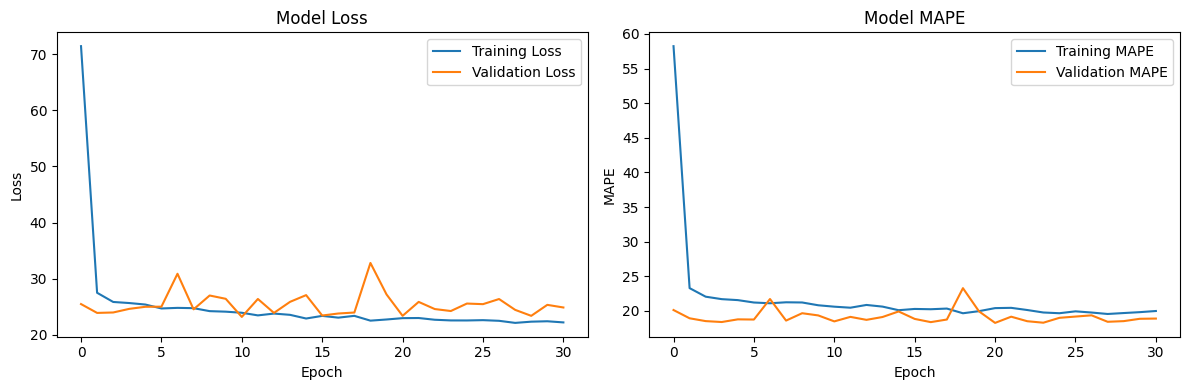

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

NameError: name 'validation_predictions' is not defined

***VORHERSAGE TESTZEITRAUM***

In [9]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Größe des Arrays (shape): (355, 1)


,0
0,133.646255
1,165.105698
2,148.051575
3,175.618393
4,100.247391
...,...
350,152.666580
351,179.085602
352,94.293640
353,167.553131


In [10]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_1"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
0,1808011,2018-08-01,1,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0
1,1808021,2018-08-02,1,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1.0,1.0
2,1808031,2018-08-03,1,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.2,1,1.0,1.0,1,1.0,1.0
3,1808041,2018-08-04,1,0,0,0,0,0,0,0.0,...,0.0,0.2,0.0,0.0,1,1.0,0.0,1,1.0,1.0
4,1808051,2018-08-05,1,0,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.0,0,1.0,1.0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,1907261,2019-07-26,1,0,0,0,0,0,0,0.0,...,0.0,0.0,0.2,0.6,1,0.0,1.0,1,1.0,0.0
351,1907271,2019-07-27,1,0,0,0,0,0,0,0.0,...,0.0,0.6,0.0,0.4,1,1.0,1.0,0,1.0,1.0
352,1907281,2019-07-28,1,0,0,0,0,0,0,0.0,...,0.0,0.4,0.6,0.2,1,1.0,0.0,1,0.0,1.0
353,1907291,2019-07-29,1,0,0,0,0,0,0,0.0,...,0.0,0.2,0.4,0.2,0,1.0,0.0,1,1.0,1.0


In [11]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Broetchen_Hochladeformat.csv"

predictions_df.to_csv('Brot_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
